## HW4 (10%)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

## Q1: the TD($\lambda$) algorithm (5%)
Consider a larger version of the Random Walk problem. 
Now we have 19 states instead of 5 and the left terminal state gives a reward of -1. 
The starting state is still the centre state. 

#### True values

In [2]:
left = 0
right = 1

n_states = 21
n_actions = 2

In [3]:
def rw():
    p = {}
    grid = np.arange(n_states)
    for s in grid:
        p[s] = {a: [] for a in range(n_actions)}

        is_done = lambda x: x == 0 or x == (n_states - 1)
        if is_done(s):
            reward = 0.
            p[s][right] = [(s, reward, True)]
            p[s][left] = [(s, reward, True)]
        else:
            reward = 0.
            s_right = s if s == (n_states - 1) else s + 1
            s_left = s if s == 0 else s - 1

            p[s][right] = [(s_right, reward, is_done(s_right))]
            p[s][left] = [(s_left, reward, is_done(s_left))]
            
            if s_left == 0:
                p[s][left] = [(s_left, -1., is_done(s_left))]
            elif s_right == (n_states-1):
                p[s][right] = [(s_right, 1., is_done(s_right))]
    return p

In [4]:
state_values = np.zeros(21)
# Assume a uniform policy
pi_a = 0.5
gam = 1.0
theta = 1e-10
transition_probs = rw()

while True:
    v_old = np.copy(state_values)
    delta = 0.0
    for s in range(n_states):
        v_s = 0.0

        for a in range(n_actions):
            current_entry = transition_probs[s][a][0]
            next_s = current_entry[0]
            reward = current_entry[1]
            v_s += pi_a * (reward + gam * v_old[next_s])

        state_values[s] = v_s
        delta = np.maximum(delta, np.abs(state_values[s] - v_old[s]))
    if delta < theta:
        break
True_values = state_values

In [5]:
True_values

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

#### Random walk environment

In [6]:
class RandomWalk:
    def __init__(self, initial_state):
        self.inis = initial_state
        self.state = self.inis
        self.reward = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        if self.state == 19 and action == right:
            self.state += 1
            self.is_terminal = True
            self.reward = 1.0
        elif self.state == 1 and action == left:
            self.state -= 1
            self.is_terminal = True
            self.reward = -1.
        else:
            if action == left:
                self.state -= 1
                self.is_terminal = False
                self.reward = 0.0

            else:
                self.state += 1
                self.is_terminal = False
                self.reward = 0.0

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.inis
        self.reward = 0.0
        self.is_terminal = False
        return self.state

In [7]:
def random_policy():
    return np.random.binomial(1, 0.5)

def TD(value, G_lambda, alpha=0.1):
    return value + alpha * (G_lambda - value)

In [62]:
def dif(lambd, alpha, true_values):    
    initial_s = 9
    env = RandomWalk(initial_s)
    episodes = 10
    values = np.zeros(21)
    total = []
    for r in range(10):
        for i in range(episodes):  
            state = env.reset()  
            done = False  

            history_r = []
            history_g = []
            history_s = []
            history_s.append(state)
            while not done: 
                a = random_policy()  
                state, r, done = env.step(a)
                history_g.append(values[state])
                history_r.append(r)
                history_s.append(state)
            history_s.pop(-1)
            num = len(history_s)
            
            for s in history_s:
                weights = (1.-lambd)*np.power(lambd, np.arange(num-1))
                weights = np.append(weights, np.power(lambd, num-1))
                weights = np.where(weights>=1e-3, weights, 0.)
                G = np.array(history_g) + np.cumsum(history_r)
                G_lambda = np.sum(G * weights)
                values[s] = TD(values[s], G_lambda, alpha)
                num -= 1

                history_g.pop(0)
                history_r.pop(0)
            
        each_run = np.square(values-true_values).sum()/19.
        total.append(each_run)
        
    return np.sqrt(np.sum(total)/10.)

In [63]:
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]
D = np.zeros((8,11))

for i in range(8):
    lambd = lambdas[i]
    alpha_v = alphas[i]
    for j in range(11):
        alpha = alpha_v[j]
        RMS = dif(lambd, alpha, True_values)
        D[i][j] = RMS

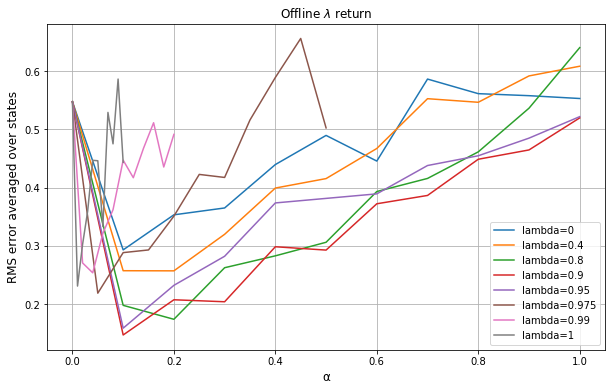

In [336]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(8):
    ax.plot(alphas[i], D[i], label=f"lambda={lambdas[i]}")
    
ax.set_xlabel(chr(945), fontsize=12)
ax.set_ylabel("RMS error averaged over states", fontsize=12)
ax.legend()
ax.set_title("Offline $\lambda$ return", fontsize=12)
ax.grid()
plt.show()

**Task**:
- Implement the off-line $\lambda$-return / TD($\lambda$) algorithm:
- Compare the RMS(root mean square) error averaged over the 19 states between the predictions at the end of the episode for the 19
states and their true values, over the first 10 episodes, and over 10 runs (10 different sequence of walks). In other words, for each run, you generate 10 episodes and use TD($\lambda$) to learn the value. Then you calculate the difference between the learned value and the true value, square the difference, average it over 10 runs and take the square root. 

- Plot the averaged RMS error vs $\alpha$ values for the following $\lambda$-values:

parameter settings: 
```
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]
```

The output should be similar figure (not necessarily the same) to this one:
![alt txt](td_lambda.png)

## Q2: Implement the double Q-learning algorithm on the Cliff Walking example (5%)

#### Task:
- Set the number of episodes to 1000
- Output the estimated optimal policy
- Plot the average reward during episodes (see the plot in Seminar 4)

In [65]:
class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

In [66]:
def dq_learning(q1, q2, a, r, alpha=0.1, gamma=1.0):  
    return q1 + alpha * (r + gamma * q2 - q1)

def eps_greedy_policy(qsa, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])

In [67]:
start_position = [3, 0]  
goal = [3, 11]
world_width = 12
world_height = 4 
# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

In [73]:
runs = 10
episodes = 1000
rewards_dq = np.zeros(episodes)

# Create two instances of the environments for comparison
env_dq_learning = CliffWalking(start_position, goal)

for r in range(runs):
    dq1 = np.zeros((world_height, world_width, len(actions)))
    dq2 = np.zeros_like(dq1)

    for i in range(episodes):
        state_dq = env_dq_learning.reset()
        
        done_dq = False
        g_dq = 0.0

        while not done_dq:
            row_dq, col_dq = state_dq
            a_dq = eps_greedy_policy(dq1[row_dq, col_dq, :]+dq2[row_dq, col_dq, :])
            next_state_dq, r_dq, done_dq = env_dq_learning.step(a_dq)
            g_dq += r_dq
            n_row_dq, n_col_dq = next_state_dq
            
            if np.random.binomial(1,0.5):
                a_1 = np.argmax(dq1[n_row_dq, n_col_dq, :])
                q2 = dq2[n_row_dq, n_col_dq, a_1]
                dq1[row_dq, col_dq, a_dq] = dq_learning(dq1[row_dq, col_dq, a_dq], q2, a_1, r_dq)
            else:
                a_2 = np.argmax(dq2[n_row_dq, n_col_dq, :])
                q1 = dq1[n_row_dq, n_col_dq, a_2]
                dq2[row_dq, col_dq, a_dq] = dq_learning(dq2[row_dq, col_dq, a_dq], q1, a_2, r_dq)
            state_dq= next_state_dq
            
        rewards_dq[i] += g_dq

In [80]:
def print_optimal_policy(policy):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11): 
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print("Double Q-learning optimal policy:")
    for row in policy_display:
        print(row)
        
pi_opt = np.argmax(dq1 + dq2, axis=2)
print_optimal_policy(pi_opt)

Double Q-learning optimal policy:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'R' 'R' 'R' 'D']
['U' 'L' 'U' 'U' 'U' 'R' 'R' 'L' 'U' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']


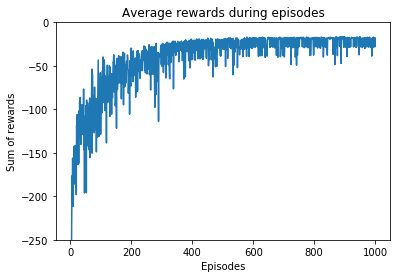

In [77]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,1001), rewards_dq/runs)
ax.set_ylim(-250,0)
ax.set_xlabel("Episodes")
ax.set_ylabel("Sum of rewards")
ax.set_title("Average rewards during episodes")
plt.show()